In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
import numpy as np
import pandas as pd
import re

#Import nltk to check english lexicon
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import (
    wordnet,
    stopwords
)

import sklearn
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)


from textblob import TextBlob
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from wordcloud import WordCloud
import seaborn as sns

In [2]:
#Replace elongated words by identifying those repeated characters and then remove them and compare the new word with the english lexicon
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), row)
    return row 

In [3]:
def replace_antonyms(word):
    #We get all the lemma for the word
    for syn in wordnet.synsets(word): 
        for lemma in syn.lemmas(): 
            #if the lemma is an antonyms of the word
            if lemma.antonyms(): 
                #we return the antonym
                return lemma.antonyms()[0].name()
    return word
            
def handling_negation(row):
    #Tokenize the row
    words = word_tokenize(row)
    speach_tags = ['JJ', 'JJR', 'JJS', 'NN', 'VB', 'VBD', 'VBG', 'VBN', 'VBP']
    #We obtain the type of words that we have in the text, we use the pos_tag function
    tags = nltk.pos_tag(words)
    #Now we ask if we found a negation in the words
    tags_2 = ''
    if "n't" in words and "not" in words:
        tags_2 = tags[min(words.index("n't"), words.index("not")):]
        words_2 = words[min(words.index("n't"), words.index("not")):]
        words = words[:(min(words.index("n't"), words.index("not")))+1]
    elif "n't" in words:
        tags_2 = tags[words.index("n't"):]
        words_2 = words[words.index("n't"):] 
        words = words[:words.index("n't")+1]
    elif "not" in words:
        tags_2 = tags[words.index("not"):]
        words_2 = words[words.index("not"):]
        words = words[:words.index("not")+1] 
        
    for index, word_tag in enumerate(tags_2):
        if word_tag[1] in speach_tags:
            words = words+[replace_antonyms(word_tag[0])]+words_2[index+2:]
            break
            
    return ' '.join(words)

In [4]:
def stop_words(text):
    #We need to remove the stop words
    stop_words_list = stopwords.words('english')
    text = text.str.lower()
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    return text

In [5]:
def get_sentiment(df):
    df[['polarity', 'subjectivity']] = df.text.apply(lambda x: pd.Series(TextBlob(x).sentiment))
    for index, row in df.text.iteritems():
        score = SentimentIntensityAnalyzer().polarity_scores(row)
        neg = score['neg']
        neu = score['neu']
        pos = score['pos']
        comp = score['compound']
        if neg > pos:
            df.loc[index, 'sentiment'] = "negative"
        elif pos > neg:
            df.loc[index, 'sentiment'] = "positive"
        else:
            df.loc[index, 'sentiment'] = "neutral"
        df.loc[index, 'neg'] = neg
        df.loc[index, 'neu'] = neu
        df.loc[index, 'pos'] = pos
        df.loc[index, 'compound'] = comp
    return df

In [6]:
def drawSentimentGraph(df, place):
    labels = df['sentiment'].drop_duplicates().values
    stat = df['sentiment'].value_counts().map(lambda x: x / len(df)).values
    fig, ax = plt.subplots()
    plt.ylim(0,1)
    rect = ax.bar(labels, stat)
    ax.set_title('The percentage of positive, neutral, and negative')
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Sentiment')

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    [ax.text(i - .13, v + .05, "{:.2%}".format(v)) for i, v in enumerate(stat)]

    plt.grid(b=None)
    plt.savefig(f'./results/sentiment_bar_{place}')
    plt.show()
    plt.clf()

In [7]:
def printWordCloud(df, sen_type, location):
    allwords=' '.join(df['text'])
    wordcloud=WordCloud(width=500, height=300,random_state=21,max_font_size=100,
                        background_color = 'white', stopwords=["hong kong", "vaccine", 
                                                                "hong", "kong", "israel"]).generate(allwords)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f'./results/worldcloud_bar_{location}_{sen_type}')
    plt.show()
    plt.clf()

In [8]:
#preprocess text in tweets by removing links, @UserNames, blank spaces, etc.
def cleanTxt(text):
    #put everythin in lowercase
    text = text.str.lower()
    #Replace rt indicating that was a retweet
    text = text.str.replace('rt', '')
    #Replace occurences of mentioning @UserNames
    text = text.replace(r'@\w+', '', regex=True)
    #Replace links contained in the tweetext = text.replace(r'http\S+', '', regex=True)
    text = text.replace(r'www.[^ ]+', '', regex=True)
    #remove numbers
    text = text.replace(r'[0-9]+', '', regex=True)
    #replace special characters and puntuation marks
    text = text.replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    return text    

def preprocessing_text(df):
    #This function will process all the required cleaning for the text in our tweets
    df.text = cleanTxt(df.text)
    df.text = df.text.apply(lambda x: detect_elongated_words(x))
    df.text = df.text.apply(lambda x: handling_negation(x))
    df.text = stop_words(df.text)
    df.drop_duplicates(subset=['text'],inplace = True)
    return df

In [9]:
def vectorization(text):
    #CountVectorizer will convert a collection of text documents to a matrix of token counts
    #Produces a sparse representation of the counts 
    #Initialize
    vector = CountVectorizer()
    #We fit and transform the vector created
    frequency_matrix = vector.fit_transform(text)
    #Sum all the frequencies for each word
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    #Now we use squeeze to remove single-dimensional entries from the shape of an array that we got from applying np.asarray to
    #the sum of frequencies.
    frequency = np.squeeze(np.asarray(sum_frequencies))
    #Now we get into a dataframe all the frequencies and the words that they correspond to
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names()).transpose()
    return frequency_df

In [10]:
def frequency_graph(word_frequency, sent, location):
    labels = word_frequency[0][1:51].index
    title = "Word Frequency for %s" %sent
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), word_frequency[0][1:51], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel("50 more frequent words", size=14);
    plt.ylabel("Frequency", size=14);
    #plt.title('Word Frequency for %s', size=18) %sent;
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.savefig(f'./results/frequency_bar_{location}_{sent}')
    plt.show()
    plt.clf()

In [11]:
def regression_graph(table, location):
    table = table[1:]
    #We set the style of seaborn
    sns.set_style("whitegrid")   
    #Initialize the figure
    plt.figure(figsize=(6,6))
    
    #we obtain the points from matplotlib scatter
    points = plt.scatter(table["Positive"], table["Negative"], c=table["Positive"], s=75, cmap="bwr")
    #graph the colorbar
    plt.colorbar(points)
    #we graph the regplot from seaborn
    sns.regplot(x="Positive", y="Negative",fit_reg=False, scatter=False, color=".1", data=table)
    plt.xlabel("Frequency for Positive Tweets", size=14)
    plt.ylabel("Frequency for Negative Tweets", size=14)
    plt.title("Word frequency in Positive vs. Negative Tweets", size=14)
    plt.grid(False)
    sns.despine()
    plt.savefig(f'./results/regression_{location}')

# Main Function

In [12]:
location = os.getenv("location")
df = pd.read_csv(f'./dataset/tweet-df-{location}.csv', sep=',', lineterminator='\n')
print(location)

israel


In [13]:
df = preprocessing_text(df)

In [14]:
df = get_sentiment(df)

In [15]:
print(len(df))

308


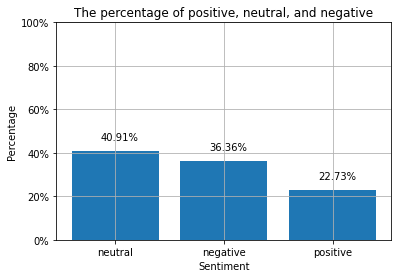

<Figure size 432x288 with 0 Axes>

In [16]:
drawSentimentGraph(df, location)

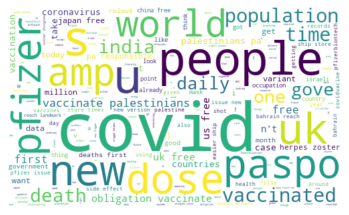

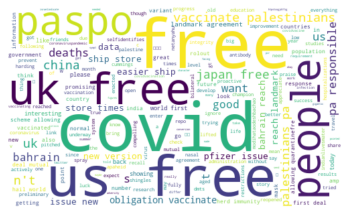

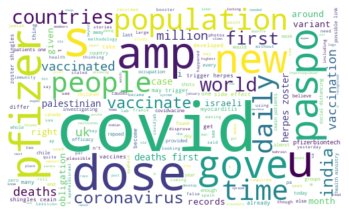

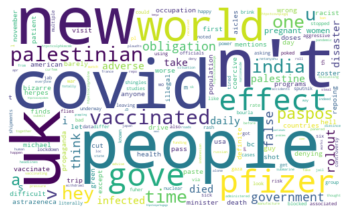

<Figure size 432x288 with 0 Axes>

In [17]:
#For All tweets
printWordCloud(df, "all", location)
#For positive tweets
printWordCloud(df[df["sentiment"]=="positive"], "pos", location)
#For neutral tweets
printWordCloud(df[df["sentiment"]=="neutral"], "neu", location)
#For negative tweets
printWordCloud(df[df["sentiment"]=="negative"], "neg", location)

In [18]:
#Get the frequency
word_frequency = vectorization(df.text).sort_values(0, ascending = False)
word_frequency_pos = vectorization(df.text[df['sentiment'] == 'positive']).sort_values(0, ascending = False)
word_frequency_neu = vectorization(df.text[df['sentiment'] == 'neutral']).sort_values(0, ascending = False)
word_frequency_neg = vectorization(df.text[df['sentiment'] == 'negative']).sort_values(0, ascending = False)

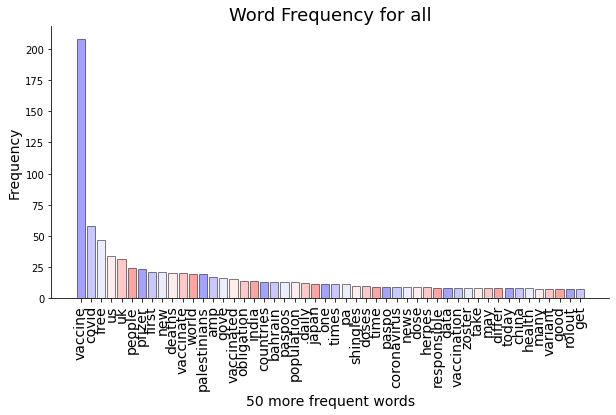

<Figure size 432x288 with 0 Axes>

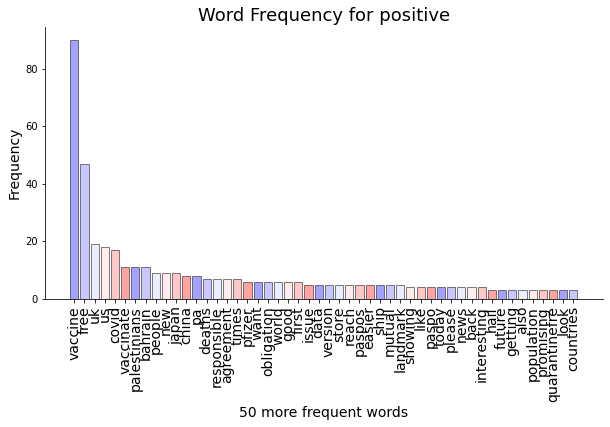

<Figure size 432x288 with 0 Axes>

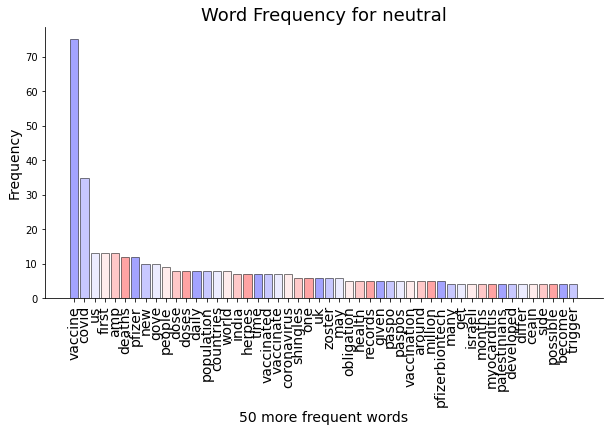

<Figure size 432x288 with 0 Axes>

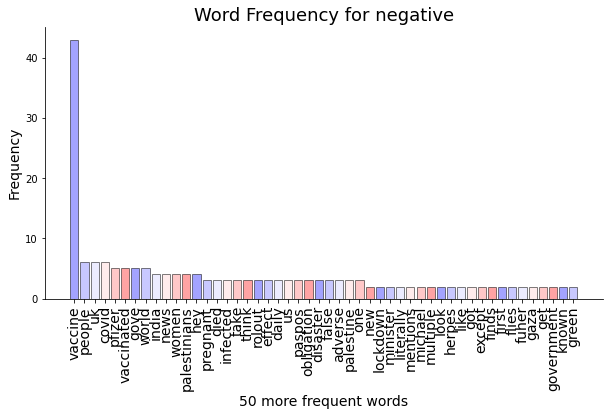

<Figure size 432x288 with 0 Axes>

In [19]:
#Graph with frequency words all, positive, neutral and negative tweets and get the frequency
frequency_graph(word_frequency, 'all', location)
frequency_graph(word_frequency_pos, 'positive', location)
frequency_graph(word_frequency_neu, 'neutral', location)
frequency_graph(word_frequency_neg, 'negative', location)

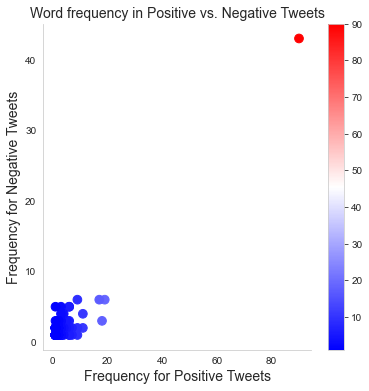

In [20]:
#Concatenate word frequency for positive and negative
table_regression = pd.concat([word_frequency_pos, word_frequency_neg], axis=1, sort=False)
table_regression.columns = ["Positive", "Negative"]
regression_graph(table_regression, location)

# Add sentiment to retweet graph

In [21]:
edge = pd.read_csv(f'./dataset/edge-{location}.csv', sep=',')

In [22]:
edge = preprocessing_text(edge)

In [23]:
edge = get_sentiment(edge)

In [24]:
edge.to_csv(f'./dataset/edge-{location}.csv', index=False)